# AI COM2028 COURSEWORK JUPYTER NOTEBOOK

#### Overview <br />
This coursework concerns the automated classification of images through machine learning techniques. You will work on bloodcell image data, where training samples and their
ground truth are provided. You will develop suitable classification techniques to classify
unseen examples, a poster to introduce the problem. You will need to submit a Jupyter
notebook containing your code for training and evaluation, your prediction outcome of the
test dataset, and a poster by 4pm on Wednesday 10th May. Any of your experiment figures
and/or tables included in your poster need to be reproducible in the Jupyter notebook that
you submit.

### Start by importing some relevant modules

In [55]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers



# Next load in the training data images (from local machine) <br />
# IF USING COLAB, SKIP NEXT TWO CELLS AND USE ONES AFTER IT 
We can do this using skimage.io <br />
We import the imread_collection and concatenate_images functions. <br />
These alllow us to read in the images from a given path, and then the concatenate_images function allows us to convert that collection to a numpy array

In [3]:
from skimage.io import imread
from skimage.io import imread_collection, concatenate_images

#set file path for local training images
training_images_path = './COM2028_2023/train'

#imread_collection allows us to load folder of images into an array
training_images_collection = imread_collection(training_images_path + '/*.jpg')
training_images = np.concatenate([image[np.newaxis] for image in training_images_collection])
print(type(training_images))



<class 'numpy.ndarray'>


# Now we load in the ground truths (labels) (from local machine)


In [74]:
train_groundtruth_path = './COM2028_2023/train.txt'
training_image_path_list = []

#since we are loading in text (strings) we can use pythons regular file reading functionallity
ground_truths = np.array([])

def linereader(line):
	values = line.split(' ') #each line contains path, value seperated by a space
	image_path = values[0]  #path is 1st value [0]
	truth = values[1]  #truth is 2nd value [1]
	truth= truth.strip('\n') #our value has a '\n' appended to it for file formatting, we remove this
	return truth, image_path


with open(train_groundtruth_path, 'r') as file:
	for line in file:
		truth, image_path = linereader(line)
		ground_truths = np.append(ground_truths, int(truth)) #we add the value to ground_truths array
		training_image_path_list.append(image_path)

	file.close()


# ONLY RUN CELL BELOW IF USING COLAB 
# THIS CELL HANDLES LOADING OF TRAINING DATA AND ITS ASSOCIATED LABELS


In [3]:
#ONLY USE IF USING COLAB
from google.colab import drive
drive.mount('/content/drive')
#!unzip "drive/MyDrive/COM2028_2023.zip" -d "drive/MyDrive"
#DONE


Mounted at /content/drive


In [56]:
#check how many GPUs you have on the device
gpus = tf.config.list_physical_devices('GPU')
print("List of physical GPUs:", gpus)
print("Num GPUs Available: ", len(gpus))
if gpus:
# Use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
  except:
    print('no gpu')
    pass


List of physical GPUs: []
Num GPUs Available:  0


In [6]:
from skimage.io import imread
from skimage.io import imread_collection, concatenate_images

#set file path for local training images
training_images_path = 'drive/MyDrive/COM2028_2023/train'

#imread_collection allows us to load folder of images into an array
training_images_collection = imread_collection(training_images_path + '/*.jpg')
training_images = np.concatenate([image[np.newaxis] for image in training_images_collection])
print(type(training_images))



<class 'numpy.ndarray'>


In [7]:
#CELL FOR LOADING TARGET VALUES WITH COLAB
train_groundtruth_path = 'drive/MyDrive/COM2028_2023/train.txt'
training_image_path_list = []

#since we are loading in text (strings) we can use pythons regular file reading functionallity
ground_truths = np.array([])

def linereader(line):
	values = line.split(' ') #each line contains path, value seperated by a space
	image_path = values[0]  #path is 1st value [0]
	truth = values[1]  #truth is 2nd value [1]
	truth= truth.strip('\n') #our value has a '\n' appended to it for file formatting, we remove this
	return truth, image_path


with open(train_groundtruth_path, 'r') as file:
	for line in file:
		truth, image_path = linereader(line)
		ground_truths = np.append(ground_truths, int(truth)) #we add the value to ground_truths array
		training_image_path_list.append(image_path)

	file.close()



# Print out some example images from training set

In [ ]:
#print out some example training images
#print out 16 example training images using subplots(4,4), giving us 4 rows of 4 columns

for i in range(0,16):
    plt.subplot(4,4, i+1)
    plt.imshow(training_images[i])
    



# Relevance of colors <br />
The above images show three of the blood sample images. <br />
Given that the colors of the samples in all images are the same, we can reason that color is potentially meaningless in the process of classifying the images. <br />
We should instead focus on the 'shape' of the image, rather than the color. <br />
Because of this, we can convert our images to grayscale format. We do this by calculating a weighted sum of the R,G,B values of the images for each image. <br />
This is done below

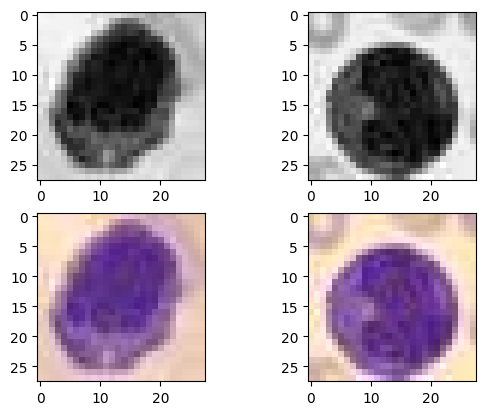

In [40]:
#formula for converting images from RGB to grayscale
#0.299 R + 0.587 G + 0.114 B

#declare an empty numpy array of dimension (1000,28,28) - to store
grayscale_training = np.empty((len(training_images),28,28), int)


for i in range(0,len(training_images)):

    image = training_images[i] 
    R = image[:,:,0] # [:] means all the points in that direction, in this case zero gets the 1st value (0) in
                    #the 3rd dimension, the 2 colons does this for all 256x256 pixels in the image
    G = image[:,:,1] #select green colors

    B = image[:, :, 2]
    gray = 0.299 * R +  0.587*G + 0.114*B

    grayscale_training[i] = gray

#now we print out grayscale images and their respective original versions


for i in range(0,4):
    if i<2:
        plt.subplot(2, 2,i+1)
        plt.imshow(grayscale_training[i], cmap = 'gray')
    else:
        plt.subplot(2,2, i+1)
        plt.imshow(training_images[i-2], cmap = 'gray')




In [9]:
print(grayscale_training.shape)

(10000, 28, 28)


# Ground truth label values range from 0-7



# Type of classifier to use <br />
Since each target can belong to one of 8 classes, we know we need to use a multiclass classifier for our model. <br /> Binary classifier is not suitable here since that only works for samples that can belong to one of two classes. <br />


In [ ]:
sample1 = training_images[0] #grabs the first training sample
print(sample1.shape)

plt.imshow(sample1)
plt.show()
#get top left pixel values
topleft_pixels = sample1[0][0]
print(topleft_pixels)
#then get ~middle pixe values
middle_pixels = sample1[14][14]
print(middle_pixels)

# First model - Multiclass KNN Classifier
For the first attempt I am going to use a KNN with the scikit-learn module <br />
KNN's are useful for multiclass classification as they allow us to classify images based on similarity to other ones. <br />
 Despite this, there are a few potential problems with using KNN for this problem
1. We have only used KNN with MNIST so far, the dataset for this problem is much larger and the KNN will therefore be more computationally expensive <br />
2. KNN can struggle with more complex images, blood sample images are arguably more complex than drawings of images (images for this are 28x28 whereas MNIST has images of size 8x8)

For the sake of analysis and testing, I am going to attempt to use a KNN for this classification task.

# Defining the KNN Classifier
### Before we define the KNN, we need to reshape some of our data
- For the input (training data), KNNs can only handle a 2d input (n_samples, sample)
- Because of this we need to reformat our input from (8000,28,28) to (8000, 28*28)


# Splitting our training data into training and validation sets <br />
Since our test set is seperate from our training set, we only have to split the data into training/validation split <br />
We will now split the grayscale images into training and validation splits of size 80:20

In [77]:
grayscale_training = grayscale_training.reshape(-1, 28*28)
sample_size = len(grayscale_training)
x_train = grayscale_training[:round(.8*sample_size)]
y_train = ground_truths[:round(.8*sample_size)]
x_valid = grayscale_training[round(.8*sample_size):]
y_valid = ground_truths[round(.8*sample_size):]
print(x_train.shape)
print(x_valid.shape)


print(x_train.shape)
print(x_valid.shape)
print(grayscale_training.shape)

print(type(ground_truths[0]))

(8000, 784)
(2000, 784)
(8000, 784)
(2000, 784)
(10000, 784)
<class 'numpy.ndarray'>


In [ ]:

total = 0 
for i in range(0,8):
    array=[]
    for x in ground_truths: 
        if x == i :
            array.append(x)
            total += 1 
    print(len(array))
    print(total)
    
    

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# to make this notebook's output stable across runs
np.random.seed(42)


#we first define the KNN classifier - we start off with N = 4 for nearest neighbours
knn_clf = KNeighborsClassifier(n_jobs = -1, weights = 'distance', n_neighbors = 5, metric = 'euclidean')

#We then fit out trainig data to the KNN
knn_clf.fit(x_train, y_train)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, weights='distance')

In [ ]:
#Now that we've fit our data to the model 
#We now need to run predictions with our validation data


y_knn_pred_valid = knn_clf.predict(x_valid)
print(accuracy_score(y_knn_pred_valid, y_valid))

0.69


# The initial accuracy score (68.5%) with our validation is not ideal
68.5% accuracy against the validation set is not high enough to make the model usable, there are various ways that we can go about addressing this issue.
One common way is to tune the hyperparameters of the model - this includes:
1. number of n_neighbours - this is the number of neighbours considered when making a prediction
2. algorithm - algorithm used when computing the nearest neighbours of a sample
3. metric - the distance metric that we use to compute distance between points, this includes Euclidian (straight line), Manhttan (absolute distance) and others

## Another thing that we can try is using Cross Validation on our model. 
Cross validation splits our data into N folds, each time one fold is used for validation and the others are used for training. KNN is prone to overfitting on training data, meaning it performs on unseen (testing) data. Using N fold Cross validation can help to mitigate this issue


# IMPORTANT THING TO REMEMBER WITH CROSS VALIDATION
WHEN USING SKLEARN CROSS VALIDATION - WE CAN PLUG IN ENTIRE TRAINING AND LABEL SET, SKLEARN AUTOMATICALLLY SPLITS IT INTO TRAINING AND VALIDATION SETS

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

#Do cross validation with different number of folds
#we will try to find the optimal number of folds for cross validation
#we will try it with between 2-10 folds

scores = []
for i in range(2,10):
    score = cross_val_score(knn_clf, grayscale_training, ground_truths, cv = i, n_jobs = -1)
    score = score.mean() # take the mean of the cross_val_scores to estimate average performance across the folds
    scores.append(score)

max_val = max(scores)
print(max_val)
index_val = scores.index(max_val) + 2

print("Best value for folds: ", index_val)




KeyboardInterrupt: 

## Plot number of folds against cross_val_score

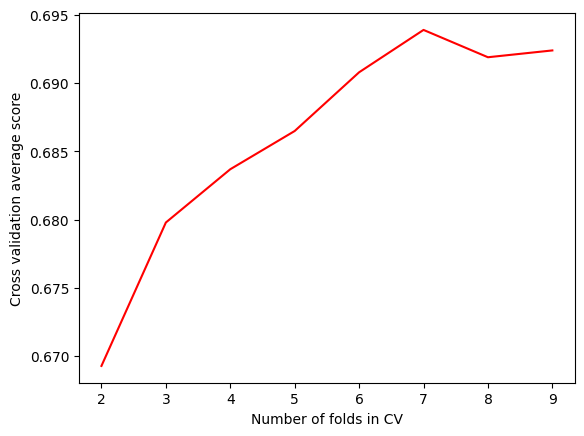

In [ ]:
xplt_values = [i for i in range(2, 10)]
y_values = scores

plt.plot(xplt_values, y_values, 'r-')
plt.xlabel("Number of folds in CV")
plt.ylabel("Cross validation average score")
plt.show()

# From the above graph
We can see that there is minimal change in the cross_val_score when using folds between 5 and 9 , with the score peaking with 7 folds <br />
For this reason we will choose 7 as a good number of folds to use and then go with this to tune the other hyperparameters

In [11]:
from sklearn.model_selection import cross_val_score
knn_clf = KNeighborsClassifier()
score = cross_val_score(knn_clf, grayscale_training, ground_truths, n_jobs = -1, cv=7 ).mean()
print(score)

0.6954004134893986


## Now we want to find optimal number of n_neighbours
This is the number of neighbours each sample considers when being classified as a given target <br />
We can do this using GridSearch


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

hyperparameters = {'n_neighbors': [3,5,7,9,11,13,15]}

In [17]:
#TESTING SHIT
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from pyspark.sql import SparkSession
from skopt.spark import SparkTrials
import numpy as np

ModuleNotFoundError: No module named 'pyspark'

In [18]:
#Now we run GridSearch to find optimal value for nearest neighbours


grid_search = GridSearchCV(knn_clf, hyperparameters, cv = 7)
grid_search.fit(grayscale_training, ground_truths)

GridSearchCV(cv=7, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15]})

In [19]:
#Once we have run that, we have *optimal values for n_neighbours and fold count (cv)
optimal_neighbors = grid_search.best_params_['n_neighbors']
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_neighbors, weights = 'distance')
score = cross_val_score(knn_optimal, grayscale_training, ground_truths, cv = 7).mean()


print("Accuracy of this model with ",optimal_neighbors, "is ", score)



Accuracy of this model with  15 is  0.7249012971178674


# Progress up to this point
So far we have determined an appropriate value for CV folds and N nearest neighbours <br />
We have done this using Euclidian (straight line) distance between points for classification <br />
Up to this point our model has a validation accuracy of 72%, not great, not terrible

# Running Grid Search with multiple hyperparameters
## Our KNN classifier has multiple hyperparameters
- Given that each of our hyperparameters has a relatively small range of values, its worth running grid search with all of the hyperparameter options.
- By doing this we are guaranteed to find the optimal set of hyperparameters within the defined ranges.


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#First we make a dictionary containing all of the hyper-params as keys and the range of values as their keys
param_grid = {
    'n_neighbors': [5,7,9,11,13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean','manhattan','wminkowski'],
    'p': [1,2]
}

#now we call GridSearch with our defined param_grid
#we will use the same KNN as we used above (knn_clf)
grid_search = GridSearchCV(knn_clf,param_grid=param_grid, cv = 7)
grid_search.fit(x_train, y_train)
opt_params = grid_search.best_params_

n_neighbors_opt = opt_params['n_neighbors']
weights_opt = opt_params['weights']
metric_opt = opt_params['metric']
p_opt = opt_params['p']

print(n_neighbors_opt)
print(weights_opt)
print(metric_opt)
print(p_opt)



KeyboardInterrupt: ignored

In [ ]:
score = grid_search.score(x_valid,y_valid)
print('the score for this grid search is ',score)
#best params are 13 neighbours, distance weighting, manhattan distance, and p = 1
n_neighbors_opt = 13
weights_opt = 'distance'
metric_opt = 'manhattan'
p_opt = 1 

the score for this grid search is  0.7745


In [21]:
test_clf = KNeighborsClassifier(n_neighbors= 13, weights='distance', metric= 'manhattan', p=1)
test_clf.fit(x_train, y_train)
print(test_clf.score(x_valid, y_valid))



0.7745


In [23]:
#best params are 13 neighbours, distance weighting, manhattan distance, and p = 1
n_neighbors_opt = 13
weights_opt = 'distance'
metric_opt = 'manhattan'
p_opt = 1 

# Now run grid search with last two parameters - algorithm and leaf size

In [24]:
#define param grid with above optimised values, add value ranges for the leaf size and algorithm options
param_grid_2 = {
    'n_neighbors': [n_neighbors_opt],
    'weights': [weights_opt],
    'metric': [metric_opt],
    'p': [p_opt],
    'leaf_size': [20,21,22,23],
    'algorithm': ['ball_tree', 'kd_tree','brute','auto']
}

grid_search_2 = GridSearchCV(test_clf, param_grid=param_grid_2, cv = 7)
grid_search_2.fit(grayscale_training, ground_truths)
opt_leaf_size = grid_search_2.best_params_['leaf_size']
opt_algorithm = grid_search_2.best_params_['algorithm']
print(opt_leaf_size)
print(opt_algorithm)

20
ball_tree


In [48]:
#At this point we have 'optimal' values for our KNN classifier
print(optimal_neighbors)
print(metric_opt)
print(opt_algorithm)
print(opt_leaf_size)
print(weights_opt)
print(p_opt)

optimal_KNN = KNeighborsClassifier(n_neighbors= optimal_neighbors, metric = metric_opt, algorithm= opt_algorithm, leaf_size=opt_leaf_size, weights= weights_opt, p = p_opt)
score = cross_val_score(optimal_KNN, grayscale_training, ground_truths, n_jobs = -1, cv=7 ).mean()




15
manhattan
ball_tree
20
distance
1


In [50]:
print("The final score for our KNN is ", score)

The final score for our KNN is  0.7814005938274541


# Results of KNN
#### At this point we have optimised 6 of the hyperparameters for our KNN, and ended up with a total accuracy of 78% on the validation set

# Alternative approach for hyper-parameter optimization - Bayesian Search
It is useful to optimise multiple hyperparameters for two main reasons:
1. Hyperparameters all interact together, an 'optimal' value for one might not be optimal when combined with a different hyperparameter. For this reason its a good idea to optimise hyperparameters simultaneously
2. Less code for me to write

Despite this, running bayesian optimisation can be rather computationally expensive

In [ ]:
#Use bayesian search to optimise multiple hyperparameters at once
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


#First define the different hyperparameters we want to optimise with a range of values for them
#this is done in the format of a dictionary


randomstate = np.random.RandomState(seed=42)


n_neighbor_vals = [2,3,4,5,6,7,8,9,10,11]
n_neighbor_probs = [0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.1,0.2,0.2]
n_neighbors = Categorical(categories= n_neighbor_vals, prior = n_neighbor_probs)

weight_vals = ['uniform','distance']
weight_probs = [0.2,0.8]
weights = Categorical(categories=weight_vals, prior = weight_probs)

search_spaces = {
    'n_neighbors': Categorical(categories=[2,3,4,5,6,7,8,9,10,11], prior = [0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.1,0.2,0.2]),
    'weights': Categorical(categories=['uniform','distance'], prior = [0.2,0.8])
}


#define a KNN instance and perform a Bayesian Search on it with our hyperparam values to be optimized
bayesianKNN = KNeighborsClassifier()

bayes_optimize = BayesSearchCV(bayesianKNN, search_spaces,  cv = 7, random_state=randomstate)
#we need to assign our assumption weightings to the object before fitting our data to it


bayes_optimize.fit(x_train, y_train)
score = bayes_optimize.score(x_valid,y_valid)




print(f'Best score: {bayes_optimize.best_score_:.3f}')
print(f'Best hyperparameters: {bayes_optimize.best_params_}')
print(f'Test set score: {score:.3f}')
#NEED TO FIX THE PRIOR_DISTRIBUTION NOT BEING ADDED PROPERLY


# GOOD PAIRS OF HYPERPARAMETERS TO RUN BAYESIAN SEARCH ON 
1. n_neighbours and weight
2. p and metric
3. algorithm and leaf size

### In the above cell we ran Bayesian Search to find optimal values for the n_neighbors and weights parameters of our KNN model
We can run Bayesian search with all of the hyperparameters for our KNN model, but this may be computationally expensive to do so.  <br />
Instead we can run Bayesian Search multiple time, but with pairs of the hyperparameters (as listed above), I will do this below

In [ ]:
##Run bayesian search with p and metric parameters
n_neighbors_opt = bayes_optimize.best_params_['n_neighbors']
weights_opt = bayes_optimize.best_params_['weights']
print(n_neighbors_opt)
print(weights_opt)
print('Best params so far are ',n_neighbors_opt, "neighbours and '",weights_opt,"' value for weighting")

prior_distribution = {
    'p': Integer(low = 1, high = 2 , prior = 'uniform'),
    'metric': Categorical(categories=['manhattan', 'euclidean'], prior = [0.5,0.5]),
    'n_neighbors': Categorical(categories = [n_neighbors_opt],  prior = [1]),
    'weights': Categorical(categories=[weights_opt], prior = [1])

}

bayes_optimize2 = BayesSearchCV(bayesianKNN, prior_distribution, cv = 7, random_state = randomstate)

bayes_optimize2.fit(x_train, y_train)
score = bayes_optimize2.score(x_valid,y_valid)




print(f'Best score: {bayes_optimize2.best_score_:.3f}')
print(f'Best hyperparameters: {bayes_optimize2.best_params_}')
print(f'Test set score: {score:.3f}')
#NEED TO FIX THE PRIOR_DISTRIBUTION NOT BEING ADDED PROPERLY

In [ ]:
#get optimal params from above
p_opt = bayes_optimize2.best_params_['p']
metric_opt = bayes_optimize2.best_params_['metric']



# Defining the model (CNN) <br />

At this point we have tried using a KNN, optimising parameters with both GridSearch and BayesSearch. These optimisation methods have not yielded great results, and our models accuracy on validation data is not great.  <br />
At this point I will move onto using a CNN (Convolutional Neural Network) <br />

- We define a few of the hyperparameters such as learning rate, the optimizer we want to use and the loss function of choice
- Once these are defined, we then declare out model with Keras.Sequential()
- - Once we've done this we add various layers, generally in the order - convolutional -> pooling -> fully connected -> output layer




In [31]:
#Importing all libraries that are relevant to the creation and training of models
#Import relevant libraries
from keras.layers import Rescaling
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from 

# Before we use a CNN, we need to format our training data and labels 
- If we didn't do this then Keras would be unable to properly work on the data

In [82]:
#Before we use a CNN, we need to encode our target values correctly
from keras.utils import to_categorical

#one hot encode the ground_truths to vectorise them into a shape of (sample_count, target_number)
#ground_truths = to_categorical(ground_truths, num_classes=8)


#We need to reformat the training data to be of shape (sample_count, H, W, Color channels)
grayscale_training = grayscale_training.reshape(10000,28, 28 ,1)
x_train, x_valid = x_train.reshape(-1, 28, 28, 1), x_valid.reshape(-1, 28, 28, 1)


In [83]:
print(ground_truths.shape)
print(grayscale_training.shape)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)


(10000, 8)
(10000, 28, 28, 1)
(8000, 28, 28, 1)
(2000, 28, 28, 1)
(8000, 8)
(2000, 8)


In [84]:

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()
crossentropy = keras.losses.CategoricalCrossentropy()


model1 = keras.Sequential()
model1.add(Rescaling(1./255))
model1.add(Conv2D(32, kernel_size=(2,2), activation="relu", input_shape=(28,28,1)))
model1.add(Conv2D(64, kernel_size=(4,4), activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid"))
model1.add(Flatten())
#model1.add(Dense(32, activation="relu"))
model1.add(Dense(8, activation="softmax"))

model1.compile(optimizer=optimizer, metrics = [accuracy], loss = crossentropy)


history = model1.fit(grayscale_training, ground_truths, validation_data = (x_valid, y_valid), epochs=5, batch_size=32)# Access training loss
train_loss = history.history['loss']
print('Training Loss:', train_loss)
model1.summary()

Epoch 1/5
313/313 [==============================] - 46s 144ms/step - loss: 1.1154 - categorical_accuracy: 0.6178 - val_loss: 0.8111 - val_categorical_accuracy: 0.7500
Epoch 2/5
313/313 [==============================] - 30s 96ms/step - loss: 0.7656 - categorical_accuracy: 0.7361 - val_loss: 0.8170 - val_categorical_accuracy: 0.7030
Epoch 3/5
313/313 [==============================] - 31s 98ms/step - loss: 0.6995 - categorical_accuracy: 0.7609 - val_loss: 0.7129 - val_categorical_accuracy: 0.7510
Epoch 4/5
313/313 [==============================] - 33s 104ms/step - loss: 0.6627 - categorical_accuracy: 0.7692 - val_loss: 0.6090 - val_categorical_accuracy: 0.7945
Epoch 5/5
313/313 [==============================] - 33s 104ms/step - loss: 0.6237 - categorical_accuracy: 0.7795 - val_loss: 0.6144 - val_categorical_accuracy: 0.7965
Training Loss: [1.115405797958374, 0.7656455039978027, 0.6994560360908508, 0.6627426743507385, 0.6237284541130066]
Model: "sequential_10"
________________________

## The above model performs very badly, there are various reasons for this such as:
= Low epoch number - Having too few epochs for the model can (and has above) resulted in severe underfitting. The model has not been able to learn the underlying patterns of the input images, and needs more iterations in order to do so. Out model is too simple and performs poorly on training and validation data, it would also perform badly on test data (although not shown above).
- Generally unoptimised parameters - As this is the first iteration of our Neural network, the hyperparameters are inevitably unoptimised, and our model is performing much worse than it necessarily could.
- There are numerous approached we can take in order to optimise the various hyperparameters in our model

## One very obvious (and simple change) is to increase the number of epochs.
Given the number of input images, and the spatial resolution of them, a good starting epoch number could be somewhere between 30-100, rather than the 10 used above
### We will start with running the same model, just with 40 epochs rather than 5. This will result in a longer training time but will hopefully help our model to 'learn' the training data more effectively

In [85]:

learning_rate = 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()
crossentropy = keras.losses.CategoricalCrossentropy()


model1 = keras.Sequential()
model1.add(Rescaling(1./255))
model1.add(Conv2D(32, kernel_size=(2,2), activation="relu", input_shape=(28,28,1)))
model1.add(Conv2D(64, kernel_size=(4,4), activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid"))
model1.add(Flatten())
model1.add(Dense(32, activation="relu"))
model1.add(Dense(8, activation="softmax"))

model1.compile(optimizer=optimizer, metrics = [accuracy], loss = crossentropy)


history = model1.fit(grayscale_training, ground_truths, validation_split=0.2, epochs=40, batch_size=32)# Access training loss
train_loss = history.history['loss']
print('Training Loss:', train_loss)
model1.summary()

Epoch 1/40
250/250 [==============================] - 25s 98ms/step - loss: 1.7642 - categorical_accuracy: 0.3356 - val_loss: 1.3693 - val_categorical_accuracy: 0.5465
Epoch 2/40
250/250 [==============================] - 22s 88ms/step - loss: 1.1983 - categorical_accuracy: 0.5569 - val_loss: 1.1353 - val_categorical_accuracy: 0.6215
Epoch 3/40
250/250 [==============================] - 26s 105ms/step - loss: 1.0270 - categorical_accuracy: 0.6158 - val_loss: 0.9653 - val_categorical_accuracy: 0.6720
Epoch 4/40
250/250 [==============================] - 27s 109ms/step - loss: 0.9661 - categorical_accuracy: 0.6457 - val_loss: 1.0693 - val_categorical_accuracy: 0.6145
Epoch 5/40
250/250 [==============================] - 27s 107ms/step - loss: 0.9430 - categorical_accuracy: 0.6553 - val_loss: 0.9433 - val_categorical_accuracy: 0.6665
Epoch 6/40
250/250 [==============================] - 27s 108ms/step - loss: 0.9069 - categorical_accuracy: 0.6671 - val_loss: 0.9558 - val_categorical_accur

![image.png](attachment:image.png)


## Inprovement on first CNN model
By just incresaing the epoch number from 5 to 40, the loss of our model has decreased significantly. This shows that by increasing # of epochs from something very small like 5 to a more reasonable 40, we get an immediate performance boost <br />
1. If we run these models just on an old laptop CPU with no GPU, then it will take a large time as parallelisation is inherently limited. By running the epochs in parallel on a machine with a GPU, epochs will run much faster.


# Optimising the CNN 
Randomly changing the various hyper parameters is not going to work to optimise this. There are too many combinations of hyperparameters for this to be a good approach if we are trying to get an optimal set of hyperparams <br />
Because of this we will need to use similar optimisation techniques to what we used with the KNN, such as GridSearch or BayesianSearch to find the optimal set of hyperparameters for our model. <br />
We can also work on the layers in the network, as this also has a large impact on the performance of our model.
